In [1]:
# ## get test 
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CV1__7oQQl14tWzUXkr-_BJwop6Gnhbs' -O test.csv
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tG-uDCYyjwcCZyCYR7typ4lyj5x_GEIP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tG-uDCYyjwcCZyCYR7typ4lyj5x_GEIP" -O testImages.zip && rm -rf /tmp/cookies.txt
# !ls -ltr .

In [2]:
# !ls -ltr .

In [3]:
# #unzip test images into its folders
# !unzip -o testImages.zip -d ./test/ 
# !ls  ./test/*.png | wc -l
# !ls -ltr . 

In [4]:
### set parameters here or have yml file 

In [1]:
import pandas as pd
from glob import glob
# from IPython.display import Image
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics import mean_squared_error
import time 
import os
import seaborn as sns

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.autograd import Variable
import torch.nn as nn 
# from torch.optim import Adam

In [3]:
class MapDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, coordinateDf, root_dir, transform=None):
        """
        Args:
            coordinateDf (pd.DataFrame): DataFrame with image id and geographic coordinates.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.map_coordinates = coordinateDf
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.map_coordinates)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir,
                                self.map_coordinates.iloc[idx, 0] + '.png')
        image = cv.imread(img_name)
        
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = transform.resize(image, (new_h, new_w), mode='reflect', anti_aliasing=True)

        return {'image': image}

class SquareRescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        
#         print('image : ', image)
        image = cv.resize(image, (self.output_size, self.output_size))
#         image = transform.resize(image, (self.output_size, self.output_size), mode='reflect', anti_aliasing=True)

        return {'image': image}


class CenterCrop(object):
    """Crop the image in a sample centered to the middle of the image.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        image = image[((h - new_h)//2): ((h - new_h)//2) + new_h,
                      ((w - new_w)//2): ((w - new_w)//2) + new_w]

        return {'image': image}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image)}

In [5]:
# import pickle

# # copy you entirely object and save it 
# MODEL_PATH = './models/gpu_model.pkl'
# file = open(MODEL_PATH,'r')
# model = pickle.load(file)

In [6]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

In [7]:
class SimpleCNN(nn.Module):   
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.BatchNorm2d(num_features=nfeatures),
            nn.Conv2d(in_channels=nfeatures, out_channels=conv1[0], kernel_size=conv1[1], stride=conv1[2], padding=conv1[3]),
            nn.BatchNorm2d(num_features=conv1[0]),
            #ReLU(inplace=True),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=max1[0], stride=max1[1], padding=max1[2]),
            nn.Conv2d(in_channels=conv1[0], out_channels=conv2[0], kernel_size=conv2[1], stride=conv2[2], padding=conv2[3]),
            nn.BatchNorm2d(num_features=conv2[0]),
            #ReLU(inplace=True),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=max2[0], stride=max2[1], padding=max2[2]),
            nn.Conv2d(in_channels=conv2[0], out_channels=conv3[0], kernel_size=conv3[1], stride=conv3[2], padding=conv3[3]),
            nn.BatchNorm2d(num_features=conv3[0]),
            #ReLU(inplace=True),
            nn.PReLU(),
        )
        self.drop_out = nn.Dropout(p=0.1)
        ft_length=outputSize(
                        outputSize(
                            outputSize(
                                outputSize(
                                    outputSize(init_ft_length, conv1[1], conv1[2], conv1[3]), 
                                    max1[0], max1[1], max2[2]),
                                conv2[1], conv2[2], conv2[3]),
                            max2[0], max2[1], max2[2]),
                        conv3[1], conv3[2], conv3[3])
        self.linear_layers = nn.Sequential(
            nn.Linear((conv3[0]*ft_length*ft_length), (conv3[0]*ft_length*ft_length)//2),
            nn.Linear((conv3[0]*ft_length*ft_length)//2, 11)
        )
        
        self.softmax = nn.LogSoftmax(dim=1)

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear_layers(x)
        x = self.softmax(x)
        return x

In [8]:
batch_size = 500
testDF = pd.read_csv("./data/piom_new_test_10k.csv")
testDF.drop(columns=["Unnamed: 0"],inplace=True)
test_map_data = MapDataset(testDF, './data/piom_new_test_10k/', transform= transforms.Compose([
                                               SquareRescale(62),
                                               CenterCrop((61,61)),
#                                                transforms.CenterCrop([124,124]),
#                                                transforms.ToTensor(),
                                               ToTensor(),
                                           ]))

test_loader = torch.utils.data.DataLoader(test_map_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0,
                                          drop_last=False)

In [9]:
# for i_batch, sample_batch in enumerate(test_loader):
# #     break
#     print(i_batch, sample_batch['image'].size())
#     if i_batch == 0:
# # #         plt.figure()
# #         show_batch(sample_batch)
# #         plt.show()
#         break

In [10]:
#CNN parameters Simple1DCNN
init_ft_length=61
nfeatures=3
conv1 = [8, 5, 1, 2]
max1 = [2, 2, 1]
conv2 = [8, 3, 1, 1]
max2 = [2, 2, 1]
conv3 = [8, 3, 1, 1]
print('Training batch size: ',batch_size)

Training batch size:  500


In [11]:
MODEL_PATH = './models/gpu_model.pth'
# defining the model
model = SimpleCNN()

# model on GPU if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.float()
model = model.to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

print(model)

SimpleCNN(
  (cnn_layers): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): PReLU(num_parameters=1)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): PReLU(num_parameters=1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): PReLU(num_parameters=1)
  )
  (drop_out): Dropout(p=0.1, inplace=False)
  (linear_layers): Sequential(
    (0): Linear(in_features=2048, out_feat

In [12]:
startTime = time.time()
test_predicted = []
total_step = len(test_loader)
for i_batch, sample_batch in enumerate(test_loader):
    # prediction for validation set
    with torch.no_grad():
        test_X = sample_batch['image'].float().to(device)
        outputs = model(test_X)
        softmax = torch.exp(outputs).cpu()
        prob = list(softmax.detach().numpy())
        predicted = np.argmax(prob, axis=1)
        test_predicted.extend(predicted)
    print('batch {}/{}, Predicted'
          .format(i_batch + 1, total_step))
print("Test time: ", time.time()-startTime) 

batch 1/20, Predicted
batch 2/20, Predicted
batch 3/20, Predicted
batch 4/20, Predicted
batch 5/20, Predicted
batch 6/20, Predicted
batch 7/20, Predicted
batch 8/20, Predicted
batch 9/20, Predicted
batch 10/20, Predicted
batch 11/20, Predicted
batch 12/20, Predicted
batch 13/20, Predicted
batch 14/20, Predicted
batch 15/20, Predicted
batch 16/20, Predicted
batch 17/20, Predicted
batch 18/20, Predicted
batch 19/20, Predicted
batch 20/20, Predicted
Test time:  305.5052728652954


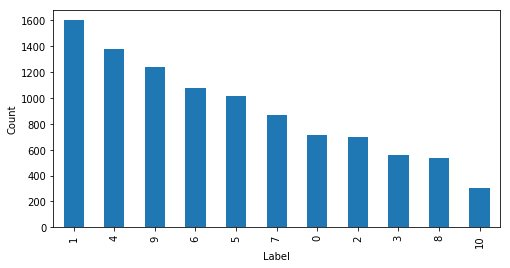

1     1603
4     1383
9     1237
6     1075
5     1017
7      869
0      715
2      696
3      562
8      537
10     306
Name: predicted_geo_zone, dtype: int64


In [13]:
##Visualizing distribution of the predicted geographic zones
testDF['predicted_geo_zone'] = test_predicted
plt.figure(figsize=(8, 4))
testDF['predicted_geo_zone'].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()
print(testDF['predicted_geo_zone'].value_counts())

In [14]:
#more precised zones
def classify_geographic_zones(row):
#     print(type(row['llcrnrlon']))
    if row['llcrnrlon']<-100. and row['llcrnrlat']>30.:
        return(0) #AmNW
    elif row['llcrnrlon']<-30. and row['llcrnrlat']>30.:
        return(1) #AmNE
    elif row['llcrnrlon']<-30. and row['llcrnrlat']>0.:
        return(2) #AmC
    elif row['llcrnrlon']<-30. and row['llcrnrlat']<=0.:
        return(3) #AmS
    elif row['llcrnrlon']<90. and row['llcrnrlat']>45.:
        return(4) #EuN
    elif row['llcrnrlon']<60. and row['llcrnrlat']>20.:
        return(5) #Med
    elif row['llcrnrlon']<60. and row['llcrnrlat']<=20.:
        return(6) #Af
    elif row['llcrnrlat']>35.:
        return(7) #AsE
    elif row['llcrnrlat']>5.:
        return(8) #AsS
    elif row['llcrnrlat']>-20.:
        return(9) #Ind
    else:
        return(10) #Aus

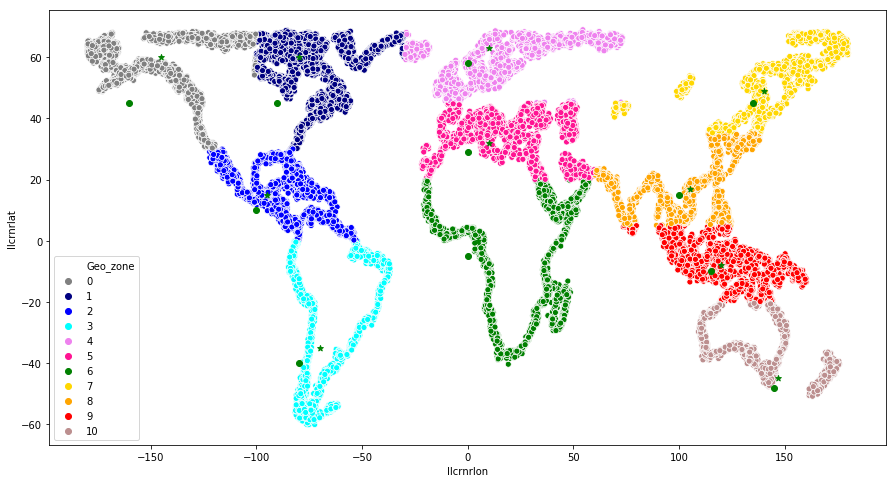

In [15]:
##Read train csv file
trainDF = pd.read_csv("./data/piom_train_30k.csv")
trainDF.drop(columns=["Unnamed: 0"],inplace=True)
trainDF['Geo_zone'] = trainDF.apply(classify_geographic_zones, axis=1)
colors = ['grey', 'navy', 'blue', 'cyan', 'violet', 'deeppink', 'green', 'gold', 'orange', 'red', 'rosybrown']
plt.figure(figsize = (15,8))
sns.scatterplot(trainDF['llcrnrlon'], trainDF['llcrnrlat'], hue=trainDF['Geo_zone'], palette=colors)

llcrnrlon = [-160, -90, -100, -80, 0, 0, 0, 135, 100, 115, 145]
llcrnrlat = [45, 45, 10, -40, 58, 29, -5, 45, 15, -10, -48]
urcrnrlon = [-145, -80, -95, -70, 10, 10, 5, 140, 105, 120, 147]
urcrnrlat = [60, 60, 15, -35, 63, 32, 0, 49, 17, -8, -45]
plt.scatter(llcrnrlon, llcrnrlat, c='green', marker='o')
plt.scatter(urcrnrlon, urcrnrlat, c='green', marker='*')
plt.show()

In [16]:
#more precised zones
def get_coordinates_from_geographic_zones(row):
#     print(row)
    if row['predicted_geo_zone']==0:
        return(-160., 45., -145., 60.) #AmNW
    elif row['predicted_geo_zone']==1:
        return(-90., 45., -80., 60.) #AmNE
    elif row['predicted_geo_zone']==2:
        return(-100., 10., -95., 15.) #AmC
    elif row['predicted_geo_zone']==3:
        return(-80., -40, -70, -35) #AmS
    elif row['predicted_geo_zone']==4:
        return(0., 58., 10., 63.) #EuN
    elif row['predicted_geo_zone']==5:
        return(0., 29., 10., 32.) #Med
    elif row['predicted_geo_zone']==6:
        return(0., -5., 5., 0.) #Af
    elif row['predicted_geo_zone']==7:
        return(135., 45., 140., 49.) #AsE
    elif row['predicted_geo_zone']==8:
        return(100., 15., 105., 17.) #AsS
    elif row['predicted_geo_zone']==9:
        return(115., -10., 120., -8.) #Ind
    else:
        return(145., -48., 147., -45.) #Aus

In [17]:
testDF.head()

,id,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,predicted_geo_zone
0,00086b9060,NaN,NaN,NaN,NaN,4
1,001b71f4dd,NaN,NaN,NaN,NaN,7
2,002001fdfb,NaN,NaN,NaN,NaN,1
3,0020667201,NaN,NaN,NaN,NaN,9
4,0023c139f2,NaN,NaN,NaN,NaN,1


In [18]:
# testDF[col] = testDF.apply(get_coordinates_from_geographic_zones, axis=1)
# df = df.assign(**dict(zip(["llcrnrlon","llcrnrlat","urcrnrlon","urcrnrlat"], values)))
for icol, col in enumerate (["llcrnrlon","llcrnrlat","urcrnrlon","urcrnrlat"]):
    testDF[col]=testDF.apply(lambda row: get_coordinates_from_geographic_zones(row)[icol], axis=1)
testDF.head()

,id,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat,predicted_geo_zone
0,00086b9060,0.0,58.0,10.0,63.0,4
1,001b71f4dd,135.0,45.0,140.0,49.0,7
2,002001fdfb,-90.0,45.0,-80.0,60.0,1
3,0020667201,115.0,-10.0,120.0,-8.0,9
4,0023c139f2,-90.0,45.0,-80.0,60.0,1


In [24]:
# ### define your models here and replace with random generation number 
# ##load your trained model file (h5/pb/pickle or any other format)
# ##sample keras loading model: 
# ##tf.keras.models.load_model(
# ##    "./trainedmodel_XEpochs_YBatch.h5", custom_objects=None, compile=True)
# ## see: https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model


# ## we defined a randome generator as our model which is NOT A SOLUTION
# def randModel(img):
#   llcrnrlon = np.random.uniform(-170,170)
#   llcrnrlat = np.random.uniform(-70,70)
#   urcrnrlon = np.random.uniform(-170,170)
#   urcrnrlat = np.random.uniform(-70,70)
#   return (llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat)



# startTestTime = time.time()
# ##Write test here
# ##Load your pretrained model here
# #resTestDF = testDF.copy()
# testDF[["llcrnrlon","llcrnrlat","urcrnrlon","urcrnrlat"]] = testDF.apply(lambda x: pd.Series(randModel(x["id"])), axis=1)
# print(testDF.head())
# print("Test took ", time.time()-startTestTime)


# # mean_squared_error(testDF[["llcrnrlonPred","llcrnrlatPred","urcrnrlonPred","urcrnrlatPred"]],testDF[["llcrnrlonPred","llcrnrlatPred","urcrnrlonPred","urcrnrlatPred"]])


In [25]:
##print results and save submission file
# RMSE = mean_squared_error(testDF[["llcrnrlon","llcrnrlat","urcrnrlon","urcrnrlat"]],testDF[["llcrnrlonPred","llcrnrlatPred","urcrnrlonPred","urcrnrlatPred"]])
# print(RMSE)
testDF[["id","llcrnrlon","llcrnrlat","urcrnrlon","urcrnrlat"]].to_csv("submission.csv")

In [41]:
# !ls -ltr . 
# !head submission.csv